### Libraries

In [ ]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pwd

'/home/zahra.ghods'

In [ ]:
original_address = '/home/zahra.ghods/Data/dataset/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [ ]:
paths = glob.glob(os.path.join(original_address + '**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [ ]:
info_train = pd.read_csv(os.path.join(original_address , 'train_labels_original.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'val_labels_original.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'test_labels_original.csv'))

In [ ]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(2522, 257, 214)

In [ ]:
info_train['path'][100], info_train['label'][100]

('Train/6VLObFIMTzq7fyUz9-ltQA/64', 'Apical-3ch')

### Preprocessing

### Define Transformers

In [ ]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))
    
class AddGaussianNoise:
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    

to_pil = ToPILImage()
    

all_data_transform = transforms.Compose([
    CustomCrop(),
#     transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Lambda(lambda x: x/255),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # AddNormalization()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),  # Brightness & contrast
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.2),
    
])


### Map images to their labels

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform, training_transform = None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.training_transform = training_transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, label, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1
        output = image_array * mask
        # visualization(mask[0], label)
        return output

    def address(self,index):
        return original_address + self.paths[index]
    
                
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filepath = original_address + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])


        # sort the image in based on the order of the slices saved in the folder
        addresses = glob.glob(os.path.join(filepath + '/', '*'))

        images_list = []
        for img_path in addresses[:10]:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)
            
        sequence_tensor = torch.stack(images_list)
        preprocessed_sequence = self.preprocessing(sequence_tensor, label)

#         image = preprocessed_sequence[int(len(preprocessed_sequence)//2)]
        image = preprocessed_sequence[1]

        if self.training_transform is not None:
            image = self.training_transform(to_pil(image))

        return image, label

In [ ]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [ ]:
train_data = CustomDataset(info_train['path'], info_train['label'], transform=all_data_transform, training_transform=train_transform)
val_data = CustomDataset(info_val['path'], info_val['label'], transform=all_data_transform)
test_data = CustomDataset(info_test['path'], info_test['label'], transform=all_data_transform)

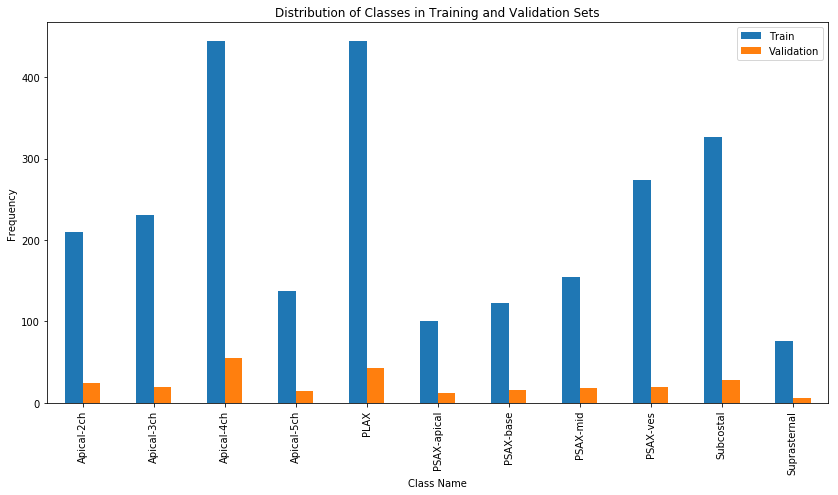

In [ ]:
train_dict = info_train['label'].value_counts().to_dict()
val_dict =info_val['label'].value_counts().to_dict()

all_classes = set(train_dict.keys()).union(set(val_dict.keys()))
train_dict_full = {cls: train_dict.get(cls, 0) for cls in all_classes}
val_dict_full = {cls: val_dict.get(cls, 0) for cls in all_classes}

df_counts = pd.DataFrame({'Train': train_dict_full, 'Validation': val_dict_full})

df_counts = df_counts.sort_index()

# df_counts = pd.DataFrame({'Train': train_counts, 'Validation': val_counts})

# Plot
ax = df_counts.plot(kind='bar', figsize=(14, 7))
ax.set_xlabel("Class Name")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Classes in Training and Validation Sets")

# Show the plot
plt.show()

In [ ]:
test_data.address(10)

'/home/zahra.ghods/Data/dataset/Test/2TmBIz3oRY6M5Iicg6qIrQ/23'

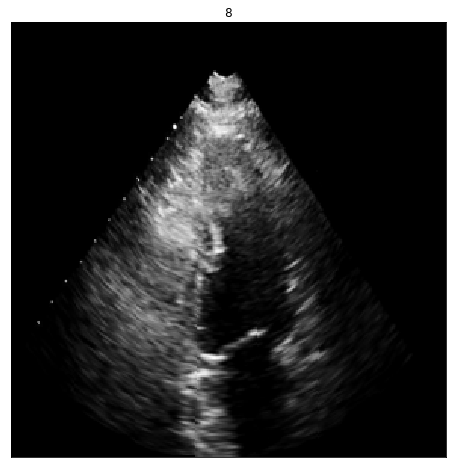

tensor(1.1848)

In [ ]:
visualization(train_data[4][0][0],train_data[1][1] )
train_data[87][0][0].max()

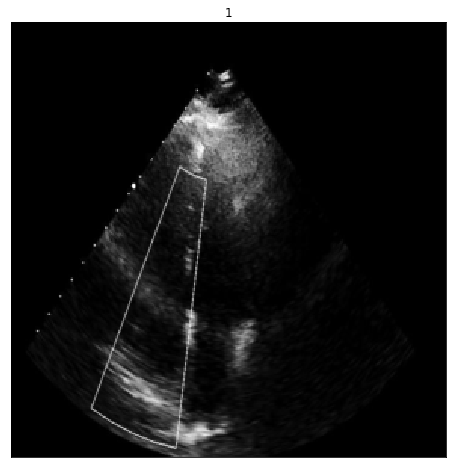

In [ ]:
visualization(test_data[67][0][0], test_data[30][1])

### Create data loaders for the train and validation sets



In [ ]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 4, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [ ]:
len(val_data)

257

### Define the neural network model architecture

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # self.conv = torchvision.models.resnet18(pretrained = False)
        self.conv = torchvision.models.efficientnet_b2(pretrained=True)
#         self.conv = torchvision.models.resnext50_32x4d(pretrained = 'True')
#         self.conv = torchvision.models.googlenet(pretrained=False,dropout = 0.3)

        # self.conv = torchvision.models.inception_v3(weights='DEFAULT')

        self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

    def forward(self, x):
        batch_size , C, H, W = x.size()
        c_out = self.conv(x)
#         c_out = c_out[0] #just google net
        output = self.classifier_layer(c_out)
        return output

cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

In [ ]:
input1 = torch.rand(8, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1))
# print(model(input2))

tensor([[ 0.0333,  0.1306, -1.4622, -0.8954,  0.1554, -0.0152, -0.3420, -0.2936,
         -1.1426, -0.3669, -0.3638],
        [-1.3141, -0.8349, -1.7787, -0.6061, -0.3734,  1.3610,  0.9818,  0.3880,
         -0.3605, -1.0488,  0.2583],
        [-0.5857, -0.2031, -0.4350, -1.2260,  0.2332,  0.2493, -0.1839, -0.3356,
         -0.0423, -0.7701,  0.3683],
        [-1.1395,  0.0660, -0.8842, -0.5058,  0.5238,  1.3063, -0.0847, -0.4268,
         -0.5357, -0.0915, -0.2266],
        [ 0.7893, -1.2843,  0.1604, -0.7133, -0.3911,  0.2161,  1.1045,  0.8388,
         -0.0739, -0.7439,  0.6681],
        [-0.6912, -0.4425, -0.0411, -0.7821, -0.6852, -0.5708,  0.5898,  0.0212,
          0.2574, -0.8168, -0.3317],
        [-0.3684,  0.0336, -0.0113, -1.1781, -0.0225, -0.5924, -0.2946,  0.0593,
         -0.0161, -0.9001,  0.0456],
        [-0.5978, -0.5875, -0.4385, -0.2790,  0.0400, -0.1025,  0.0804,  0.5536,
         -0.0930, -1.0411,  0.3037]], grad_fn=<AddmmBackward0>)


### Define loss and optimizer

In [ ]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [ ]:
def evaluate(model, loader, device, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      total_loss += loss.item() * images.size(0)
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [ ]:
# model = model.to(device)
epochs = 20
# BATCH_SIZE = 64
accs = []
losses = []
val_loss = 0.0
best_val_loss = float('inf')
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  # epochs_no_improve = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # print('TRAIN:', predictions, labels,  running_corrects, '\n')
    # total_loss += loss.item() * images.size(0)
    
  # accuracy = total_correct / total

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc
    best_val_loss = val_loss
    epochs_no_improve = 0
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 4 and epoch > 7:
    print('no further improvement ', best_acc)
    break


Train epoch 0: Loss(1.7176, Accuracy (0.41907) )
valid epoch 0: Loss(1.2334),  Accuracy (0.5977))
---
Train epoch 1: Loss(1.1259, Accuracy (0.60697) )
valid epoch 1: Loss(0.8639),  Accuracy (0.6797))
---
Train epoch 2: Loss(0.8551, Accuracy (0.70833) )
valid epoch 2: Loss(0.6854),  Accuracy (0.7695))
---
Train epoch 3: Loss(0.7277, Accuracy (0.75641) )
valid epoch 3: Loss(0.7969),  Accuracy (0.7305))
---
Train epoch 4: Loss(0.6629, Accuracy (0.77324) )
valid epoch 4: Loss(0.4700),  Accuracy (0.8359))
---
Train epoch 5: Loss(0.5782, Accuracy (0.80128) )
valid epoch 5: Loss(0.6326),  Accuracy (0.8125))
---
Train epoch 6: Loss(0.5082, Accuracy (0.82933) )
valid epoch 6: Loss(0.5646),  Accuracy (0.8008))
---
Train epoch 7: Loss(0.4790, Accuracy (0.84014) )
valid epoch 7: Loss(0.5018),  Accuracy (0.8281))
---
Train epoch 8: Loss(0.3842, Accuracy (0.87059) )
valid epoch 8: Loss(0.5816),  Accuracy (0.8242))
---
Train epoch 9: Loss(0.3756, Accuracy (0.87019) )
valid epoch 9: Loss(0.5881),  Acc

In [ ]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) 
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

evaluate(model, loader= test_loader, device = device)


Test Loss(0.6460),  Accuracy (0.8125))


(tensor(0.8125, device='cuda:0'), 0.6460201094547907)

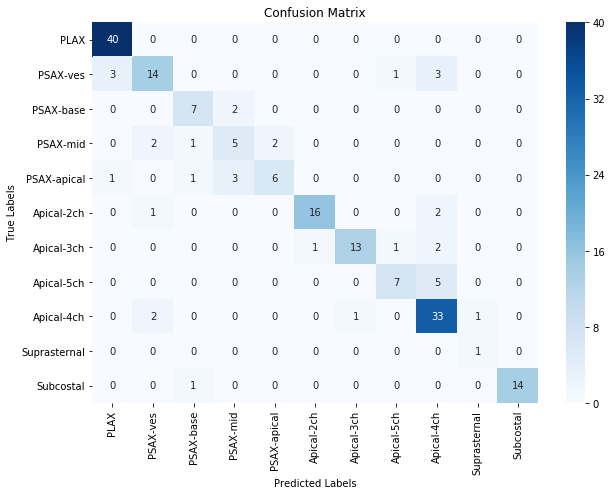

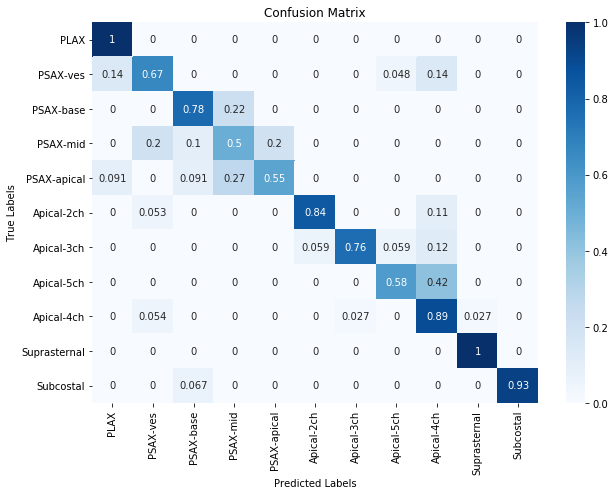

In [ ]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

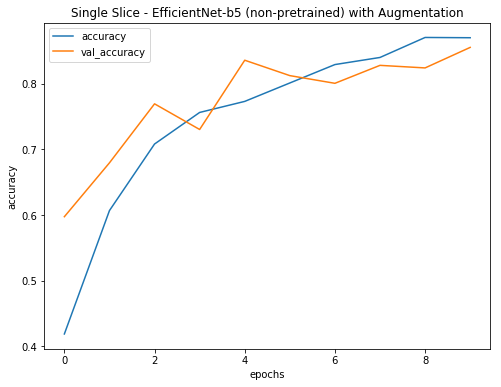

In [ ]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Single Slice - EfficientNet-b5 (non-pretrained) with Augmentation')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels